In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
from ase.io import read

import numpy as np
sys.path.insert(0, "../LML_retrain/")
from LML_retrain import LMLPotential 

In [2]:
def extract_descriptors_from_images(images, extract_derivatives=False):
    
    LML_pot = LMLPotential("../potentials/milady_lml")
    
    if extract_derivatives:
        dD = []
        for image in images:
            dD.append(LML_pot.get_dD(image).reshape(3 * len(image), -1))
        dD = np.concatenate(dD)
        print("Descriptor derivatives array shape:")
        print(dD.shape)
        
        return dD
    
    else:
        mean_D = []

        for image in images:
            mean_D.append(LML_pot.get_D(image).mean(axis=0))
        mean_D = np.array(mean_D)
        print("Mean descriptors array shape:")
        print(mean_D.shape)
        
        return mean_D

    
def extract_QMML_targets(images):
    
    LML_pot = LMLPotential("../potentials/milady_lml")
    
    target_positions = []
    target_forces = []
    target_dD = []

    for image in images:
        fix_mask = image.get_array("fix_mask")
        forces = image.get_forces()
        dD = LML_pot.get_dD(image)

        target_forces.append(forces[np.logical_not(fix_mask)])
        target_dD.append(dD[np.logical_not(fix_mask)])
        target_positions.append(image.get_positions()[np.logical_not(fix_mask)])
        
    target_forces = np.concatenate(target_forces)
    print("Target forces shape:")
    print(target_forces.shape)
    target_dD = np.concatenate(target_dD)
    print("Target dD shape:")
    print(target_dD.shape)
    target_positions = np.concatenate(target_positions)
    print("Target positions shape:")
    print(target_positions.shape)
    
    return target_positions, target_forces, target_dD


def retrain_potential(targets, A_hard, A_soft, train_configs, test_configs, lambda_0=5000., lambda_S=1.0, plot=True, title=""):
    
    LML_pot = LMLPotential("../potentials/milady_lml")
    
    target_positions, target_forces, target_dD = targets
    
    LML_pot.A_hard = A_hard
    LML_pot.A_soft = A_soft
    
    LML_pot.lambda_0 = lambda_0
    LML_pot.lambda_S = lambda_S
    
    LML_pot.refit_pot_from_forces(target_forces, target_dD)
    
    
    if plot:
        fig, axes = plt.subplots(figsize=(30, 5), ncols=6)

        LML_pot.plot_w_coefs(ax=axes[0])
        #screw_LML.plot_target_force_error(screw, ax=axes[1])
        LML_pot.plot_target_force_error(target_positions, components=False, ax=axes[1])
        LML_pot.plot_MD_test_train_atoms(train_configs=train_configs, test_config=test_configs[0], ax=axes[2])
        axes[2].set_title("bulk MD test")
        LML_pot.plot_MD_test_train_atoms(train_configs=train_configs, test_config=test_configs[1], ax=axes[3])
        axes[3].set_title("Vac MD test")
        LML_pot.plot_eos_data(eos_configs, ax=axes[4])
        LML_pot.plot_NEB_data(vacancy_migration_images, ax=axes[5])
        axes[4].set_title("Vac migration NEB ")
        
        fig.suptitle(title)
    
    return LML_pot


# Set lambdas

In [3]:
lambda_0 = 500.0
lambda_S = 1.0

folder_name = f"Lam0_{lambda_0:g}" + \
               f"_LamS_{lambda_S:g}".replace("0.", "0")


if not os.path.exists("../potentials/" + folder_name):
    os.mkdir("../potentials/" + folder_name)

In [4]:
eos_configs = read('../data_files/eos_configurations.xyz', index=":")
eos_descriptors = extract_descriptors_from_images(eos_configs)

bulk_MD_configs = read("../data_files/bulk_MD_train.xyz", index=":")
bulk_MD_dD = extract_descriptors_from_images(bulk_MD_configs, extract_derivatives=True)
bulk_MD_test = read("../data_files/bulk_MD_test.xyz")

vac_MD_configs = read("../data_files/vac_MD_train.xyz", index=":")
vac_MD_dD = extract_descriptors_from_images(vac_MD_configs, extract_derivatives=True)
vac_MD_test = read("../data_files/vac_MD_test.xyz")

vacancy_migration_images = read("../data_files/Vac_NEB_images.xyz", index=":")
vac_neb_descriptors = extract_descriptors_from_images(vacancy_migration_images)

Mean descriptors array shape:
(102, 1596)
Descriptor derivatives array shape:
(2250, 1596)
Descriptor derivatives array shape:
(2241, 1596)
Mean descriptors array shape:
(13, 1596)


# Training on screw glide QMML targets

In [5]:
screw_glide_images = read("../data_files/QMML_glide_images/screw_vasp_LML_6_12_004.xyz", index=":")
targets = extract_QMML_targets(screw_glide_images)

Target forces shape:
(18044, 3)
Target dD shape:
(18044, 3, 1596)
Target positions shape:
(18044, 3)


EOS in hard constraints and bulk MD in soft
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.0078 eV/A
Test RMSE = 0.0097 eV/A
Train RMSE = 0.0078 eV/A
Test RMSE = 0.023 eV/A
Using vacancy MD as soft constraints
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1186/1596
Train RMSE = 0.0083 eV/A
Test RMSE = 0.0093 eV/A
Train RMSE = 0.0083 eV/A
Test RMSE = 0.012 eV/A
Adding vacancy migration NEB to hard constraints
Hard constraints dimensionality: 37/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.0079 eV/A
Test RMSE = 0.0098 eV/A
Train RMSE = 0.0079 eV/A
Test RMSE = 0.017 eV/A


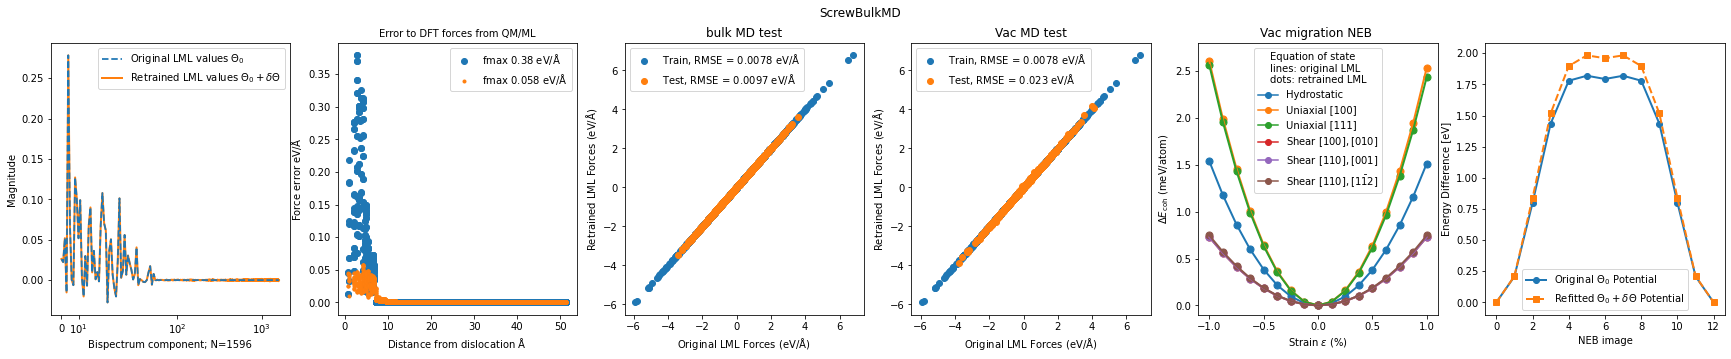

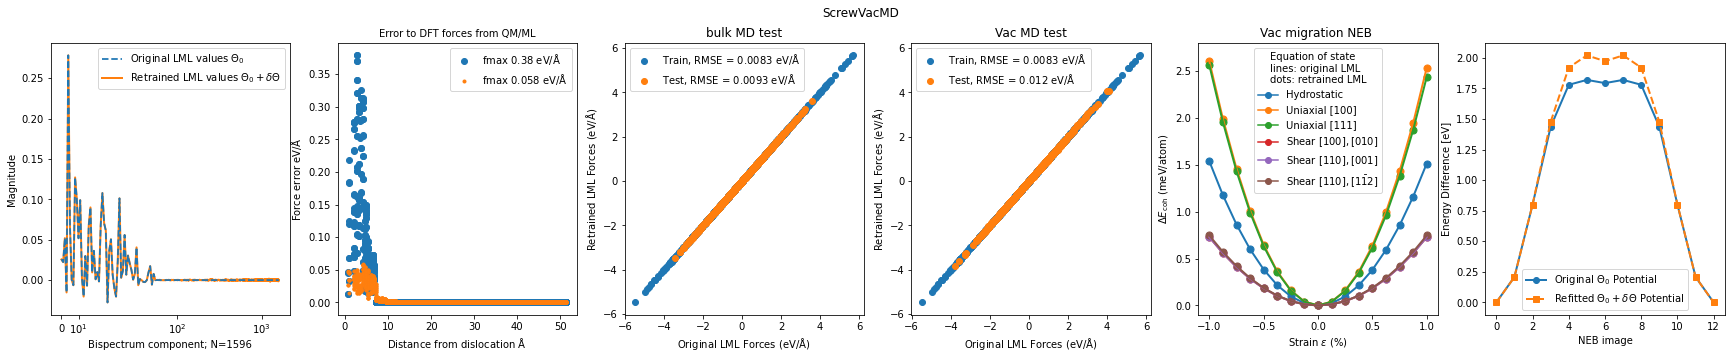

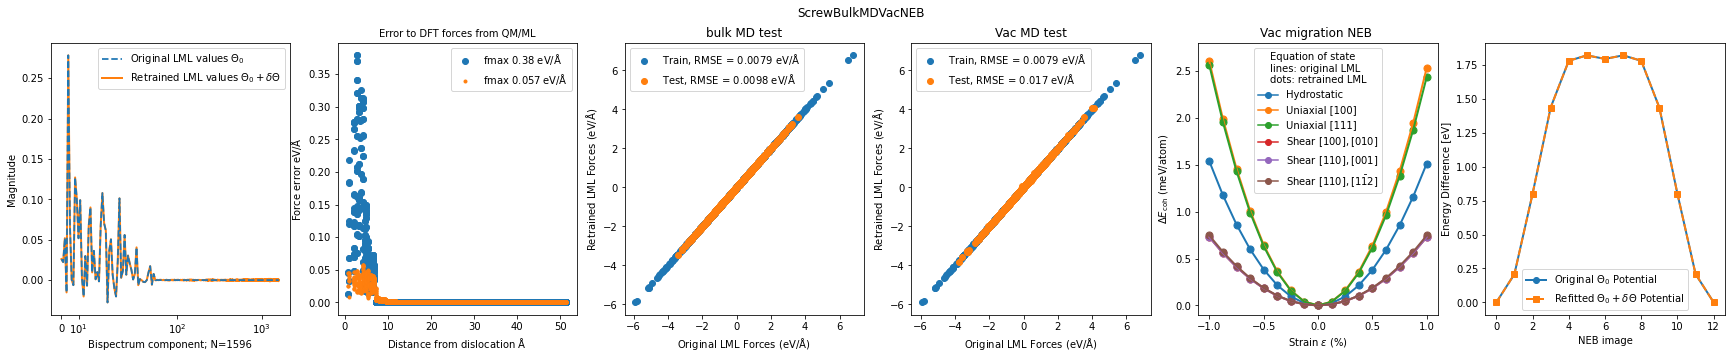

In [6]:
print("EOS in hard constraints and bulk MD in soft")

screw_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                              A_hard=eos_descriptors, # to fix elastic constants
                              A_soft=bulk_MD_dD, 
                              train_configs=bulk_MD_configs,
                              test_configs=[bulk_MD_test, vac_MD_test], 
                              lambda_0=lambda_0,
                              lambda_S=lambda_S,
                              title="ScrewBulkMD")

screw_LML.write_retrained_potential(title="ScrewBulkMD", folder="../potentials/" + folder_name + "/")

print("Using vacancy MD as soft constraints")

screw_LML = retrain_potential(targets=targets,
                              A_hard=eos_descriptors,
                              A_soft=vac_MD_dD,
                              train_configs=vac_MD_configs,
                              test_configs=[bulk_MD_test, vac_MD_test], 
                              lambda_0=lambda_0,
                              lambda_S=lambda_S,
                              title="ScrewVacMD")

screw_LML.write_retrained_potential(title="ScrewVacMD", folder="../potentials/" + folder_name + "/")

print("Adding vacancy migration NEB to hard constraints")

screw_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                              A_hard=np.vstack((eos_descriptors, vac_neb_descriptors)), # to fix elastic constants and vacancy migration
                              A_soft=bulk_MD_dD, 
                              train_configs=bulk_MD_configs,
                              test_configs=[bulk_MD_test, vac_MD_test], 
                              lambda_0=lambda_0,
                              lambda_S=lambda_S,
                              title="ScrewBulkMDVacNEB")

screw_LML.write_retrained_potential(title="ScrewBulkMDVacNEB", folder="../potentials/" + folder_name + "/")

del targets

## Training on Junction110 QMML NEB

In [7]:
Junction_110_glide_images = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")
targets = extract_QMML_targets(Junction_110_glide_images)

Target forces shape:
(64896, 3)
Target dD shape:
(64896, 3, 1596)
Target positions shape:
(64896, 3)


EOS in hard constraints and bulk MD in soft
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.01 eV/A
Test RMSE = 0.012 eV/A
Train RMSE = 0.01 eV/A
Test RMSE = 0.028 eV/A
Using vacancy MD as soft constraints
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1186/1596
Train RMSE = 0.011 eV/A
Test RMSE = 0.013 eV/A
Train RMSE = 0.011 eV/A
Test RMSE = 0.016 eV/A
Adding vacancy migration NEB to hard constraints
Hard constraints dimensionality: 37/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.01 eV/A
Test RMSE = 0.012 eV/A
Train RMSE = 0.01 eV/A
Test RMSE = 0.025 eV/A


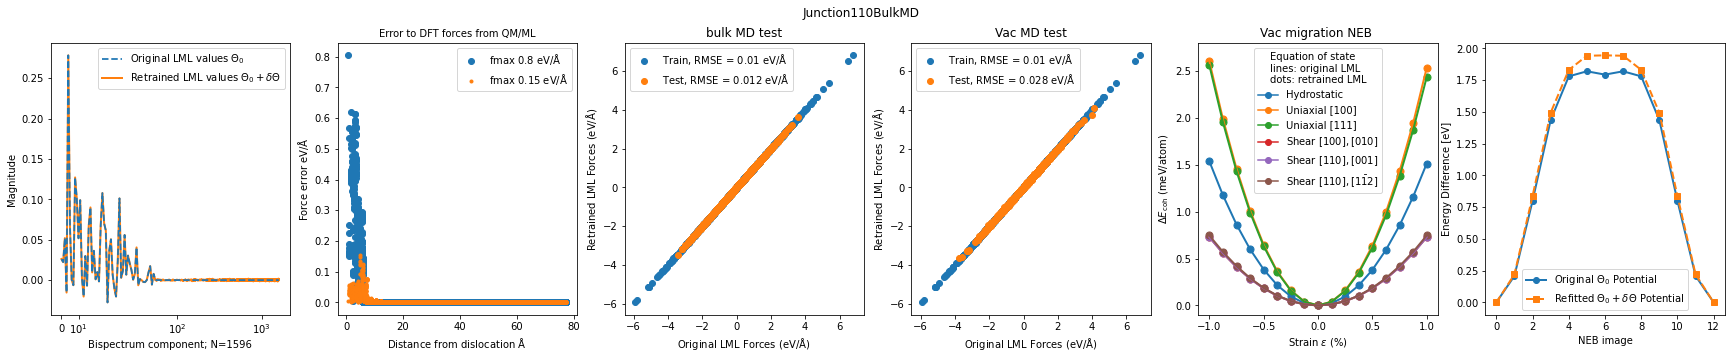

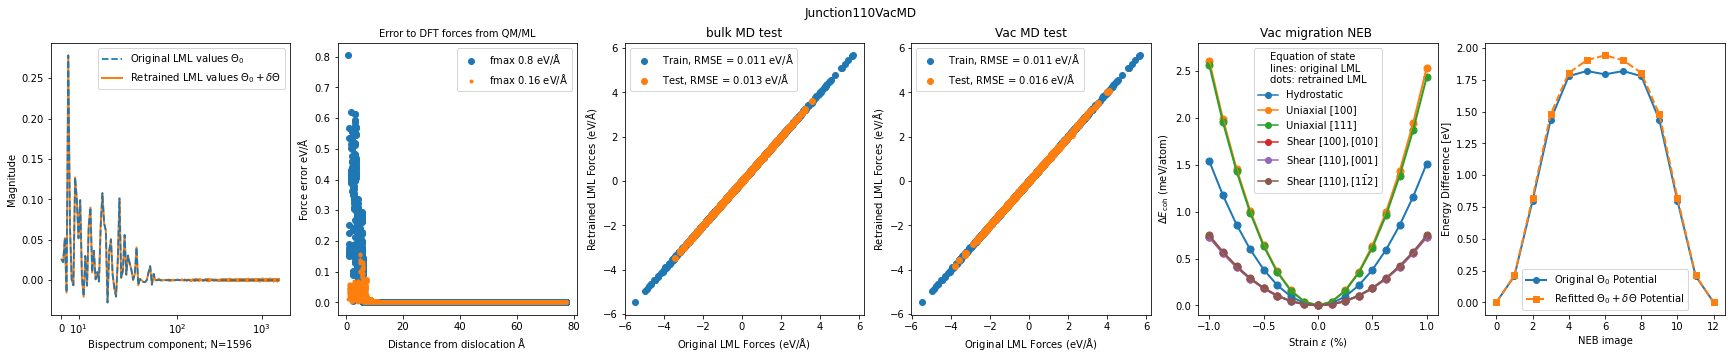

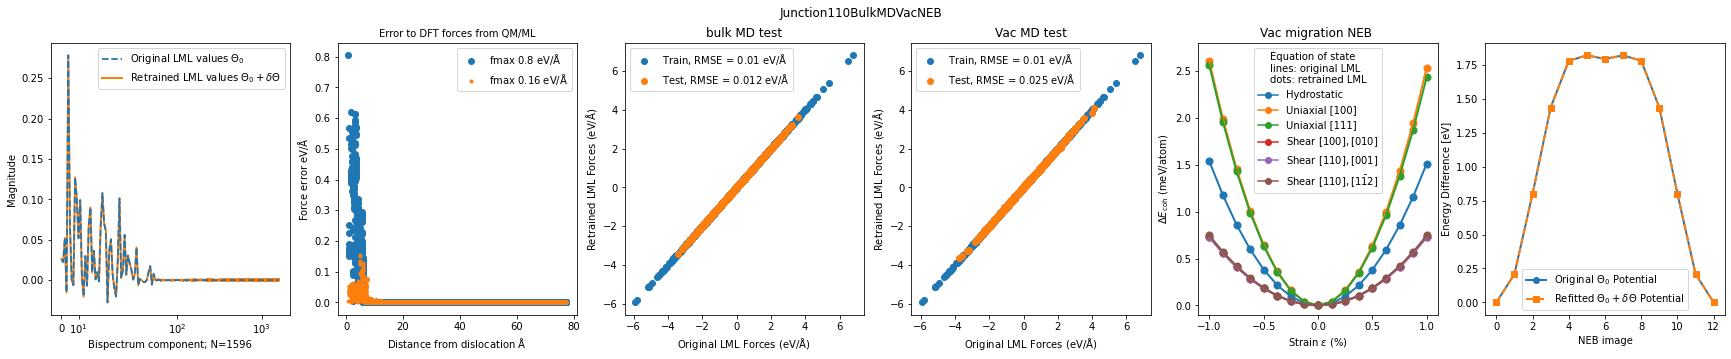

In [8]:
print("EOS in hard constraints and bulk MD in soft")

Junction110_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=eos_descriptors, # to fix elastic constants
                                    A_soft=bulk_MD_dD, 
                                    train_configs=bulk_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction110BulkMD")

Junction110_LML.write_retrained_potential(title="Junction110BulkMD", folder="../potentials/" + folder_name + "/")

print("Using vacancy MD as soft constraints")

Junction110_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=eos_descriptors, # to fix elastic constants
                                    A_soft=vac_MD_dD, 
                                    train_configs=vac_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction110VacMD")

Junction110_LML.write_retrained_potential(title="Junction110VacMD", folder="../potentials/" + folder_name + "/")

print("Adding vacancy migration NEB to hard constraints")

Junction110_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=np.vstack((eos_descriptors, vac_neb_descriptors)), # to fix elastic constants and vacancy migration
                                    A_soft=bulk_MD_dD, 
                                    train_configs=bulk_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction110BulkMDVacNEB")

Junction110_LML.write_retrained_potential(title="Junction110BulkMDVacNEB", folder="../potentials/" + folder_name + "/")

del targets

# Training on Junction100 QMML NEB

In [9]:
Junction_100_glide_images = read("../data_files/QMML_glide_images/edge100_vasp_LML_6_10_019.xyz", index=":")
targets = extract_QMML_targets(Junction_100_glide_images)

Target forces shape:
(46436, 3)
Target dD shape:
(46436, 3, 1596)
Target positions shape:
(46436, 3)


EOS in hard constraints and bulk MD in soft
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.012 eV/A
Test RMSE = 0.014 eV/A
Train RMSE = 0.012 eV/A
Test RMSE = 0.044 eV/A
Using vacancy MD as soft constraints
Hard constraints dimensionality: 25/1596
Soft constraints dimensionality: 1186/1596
Train RMSE = 0.014 eV/A
Test RMSE = 0.013 eV/A
Train RMSE = 0.014 eV/A
Test RMSE = 0.018 eV/A
Adding vacancy migration NEB to hard constraints
Hard constraints dimensionality: 37/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.012 eV/A
Test RMSE = 0.014 eV/A
Train RMSE = 0.012 eV/A
Test RMSE = 0.036 eV/A


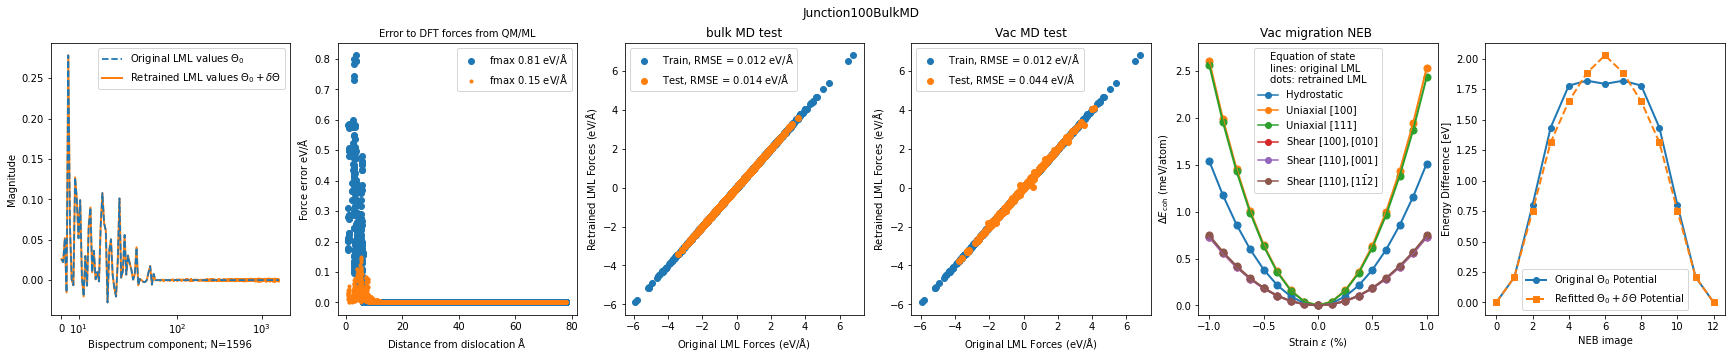

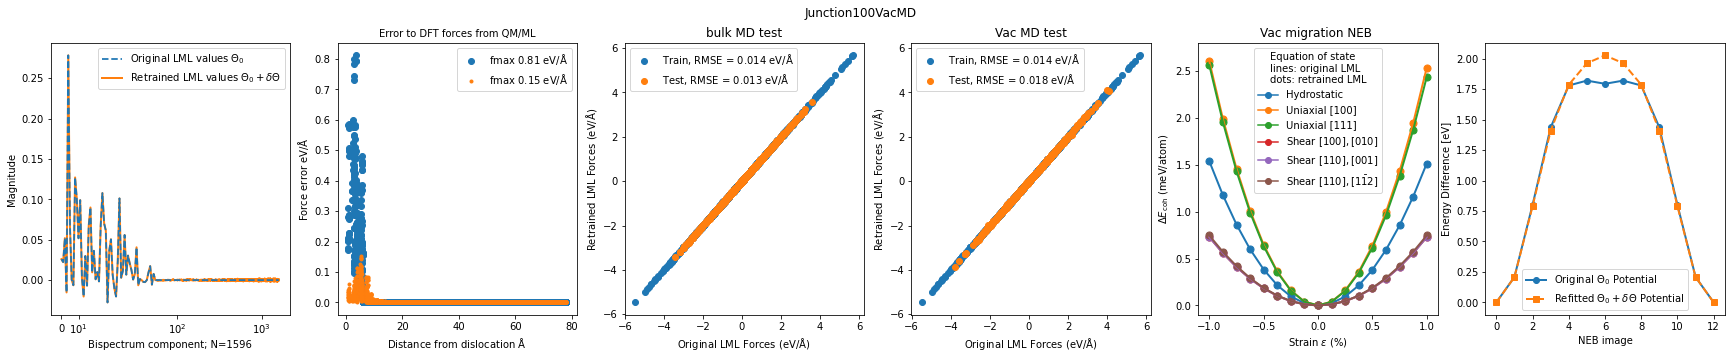

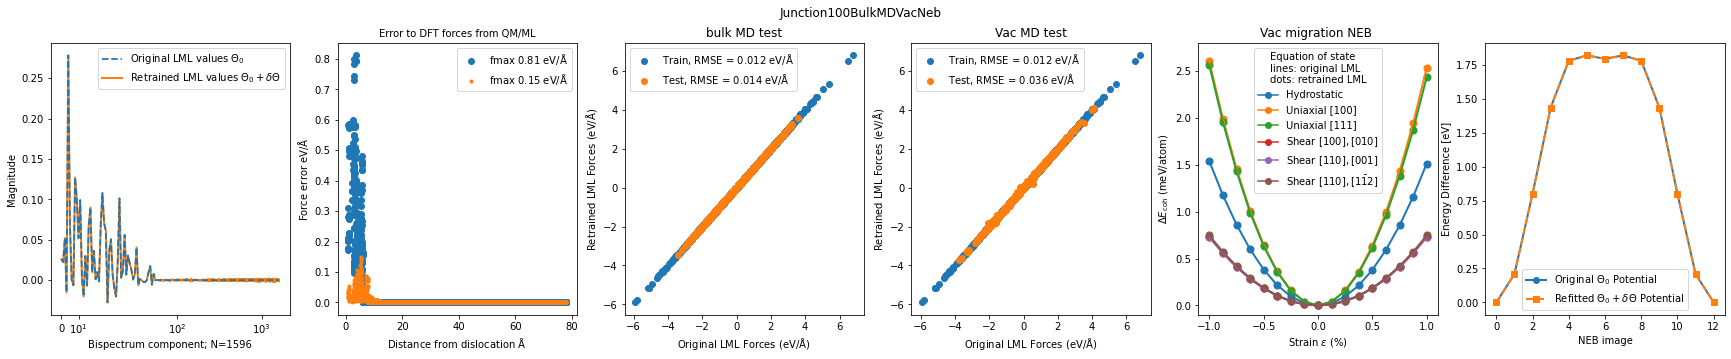

In [10]:
print("EOS in hard constraints and bulk MD in soft")

Junction100_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=eos_descriptors, # to fix elastic constants
                                    A_soft=bulk_MD_dD, 
                                    train_configs=bulk_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction100BulkMD")

Junction100_LML.write_retrained_potential(title="Junction100BulkMD", folder="../potentials/" + folder_name + "/")

print("Using vacancy MD as soft constraints")

Junction100_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=eos_descriptors, # to fix elastic constants
                                    A_soft=vac_MD_dD, 
                                    train_configs=vac_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction100VacMD")

Junction100_LML.write_retrained_potential(title="Junction100VacMD", folder="../potentials/" + folder_name + "/")

print("Adding vacancy migration NEB to hard constraints")

Junction100_LML = retrain_potential(targets=targets, # target_positions, target_forces, target_dD
                                    A_hard=np.vstack((eos_descriptors, vac_neb_descriptors)), # to fix elastic constants and vacancy migration
                                    A_soft=bulk_MD_dD, 
                                    train_configs=bulk_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction100BulkMDVacNeb")

Junction100_LML.write_retrained_potential(title="Junction100BulkMDVacNEB", folder="../potentials/" + folder_name + "/")

del targets

# Adding 3d Junction110-vac segration data to training on Junction110 QMML NEB

In [5]:
junction_vac_ini = read("../data_files/relaxed_vac_at_junction110_ini.xyz")
junction_vac_fin1 = read("../data_files/relaxed_vac_at_junction110_fin1.xyz")
junction_vac_fin2 = read("../data_files/relaxed_vac_at_junction110_fin2.xyz")

LML_pot = LMLPotential("../potentials/milady_lml")

target_positions_3d = []
target_forces_3d = []
target_dD_3d = []

for image in [junction_vac_ini, junction_vac_fin1, junction_vac_fin2]:
    region = image.get_array("region")
    QM_mask = region == "QM"

    target_positions_3d.append(image.positions[QM_mask])
    target_forces_3d.append(image.get_forces()[QM_mask])

    qm_positions = image.positions[QM_mask]
    positions = image.positions
    qm_plus_10_a_mask = [all(row) for row in np.logical_and(positions > qm_positions.min(axis=0) - 10, positions < qm_positions.max(axis=0) + 10)]

    screened_atoms = image.copy()[qm_plus_10_a_mask]
    target_dD_3d.append(LML_pot.get_dD(screened_atoms)[QM_mask[qm_plus_10_a_mask]])

target_forces_3d = np.concatenate(target_forces_3d)
print("Target forces shape:")
print(target_forces_3d.shape)
target_dD_3d = np.concatenate(target_dD_3d)
print("Target dD shape:")
print(target_dD_3d.shape)
target_positions_3d = np.concatenate(target_positions_3d)
print("Target positions shape:")
print(target_positions_3d.shape)

Target forces shape:
(81, 3)
Target dD shape:
(81, 3, 1596)
Target positions shape:
(81, 3)


In [6]:
Junction_110_glide_images = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")
targets = extract_QMML_targets(Junction_110_glide_images)

target_positions, target_forces, target_dD = targets

Target forces shape:
(64896, 3)
Target dD shape:
(64896, 3, 1596)
Target positions shape:
(64896, 3)


In [7]:
extended_target_forces = np.concatenate((target_forces_3d, target_forces))
print(extended_target_forces.shape)

extended_target_positions = np.concatenate((target_positions_3d, target_positions))
print(extended_target_positions.shape)

extended_target_dD = np.concatenate((target_dD_3d, target_dD))
print(extended_target_dD.shape)



(64977, 3)
(64977, 3)
(64977, 3, 1596)


Hard constraints dimensionality: 37/1596
Soft constraints dimensionality: 1116/1596
Train RMSE = 0.013 eV/A
Test RMSE = 0.015 eV/A
Train RMSE = 0.013 eV/A
Test RMSE = 0.034 eV/A


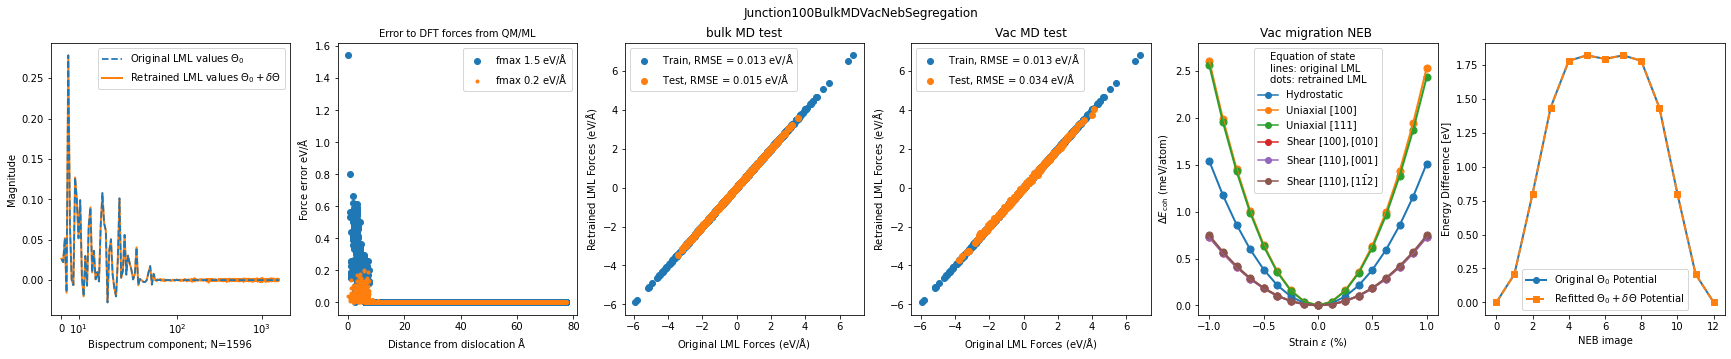

In [8]:
Junction110_LML = retrain_potential(targets=[extended_target_positions, extended_target_forces, extended_target_dD], # target_positions, target_forces, target_dD
                                    A_hard=np.vstack((eos_descriptors, vac_neb_descriptors)), # to fix elastic constants and vacancy migration
                                    A_soft=bulk_MD_dD, 
                                    train_configs=bulk_MD_configs,
                                    test_configs=[bulk_MD_test, vac_MD_test], 
                                    lambda_0=lambda_0,
                                    lambda_S=lambda_S,
                                    title="Junction100BulkMDVacNebSegregation")


In [9]:
Junction110_LML.write_retrained_potential(title="Junction110BulkMDVacNEBSegregation", folder="../potentials/" + folder_name + "/")